In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from model import SIRModel

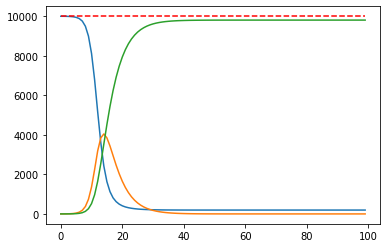

In [17]:
BETA=1.0
GAMMA=1/4
model=SIRModel(beta=BETA,gamma=GAMMA)
t=np.arange(0,100)
S0=10000
I0=1
R0=0
y_0=[S0,I0,R0]
y_t=model.predict(t,y_0)

plt.plot(t,y_t[0])
plt.plot(t,y_t[1])
plt.plot(t,y_t[2])
plt.plot(t,y_t[0]+y_t[1]+y_t[2],"r--")
plt.show()

In [18]:
model.beta_=0.90
model.gamma_=0.22
N=S0+I0
I=y_t[1]
R0=y_t[2][0]
model.fit(t, y_t, N)
print(model)
assert np.allclose(model.params, (BETA, GAMMA))

SIRModel(
	β = 1.0000 ± 0.0000,
	ɣ = 0.2500 ± 0.0000
)R0 = 4.0000



In [19]:
param_names=("BETA","GAMMA")
true_parms=(BETA,GAMMA)
for i, (p,true_p, name) in enumerate(zip(model.params,true_parms,param_names)):
    print( f"true value {name} = {true_p} ~ {p}  +/- {np.sqrt(model.params_cov_[i,i])}")

true value BETA = 1.0 ~ 0.9999999999999999  +/- 7.788047323887707e-17
true value GAMMA = 0.25 ~ 0.25  +/- 5.872822759184539e-17


# Fit model à un jeu de donnée

In [20]:
#chargement et transformation des données 

data_dir = 'data'

#Load data
tests_depistage_latest = pd.read_csv(os.path.join(data_dir,
                                                  'donnees-tests-covid19-labo-quotidien-2020-05-29-19h00.csv'),
                                     sep=';')

hospital_latest = pd.read_csv(os.path.join(data_dir, 'donnees-hospitalieres-covid19-2020-06-18-19h00.csv'),
                              sep=';')

tests_depistage_latest['jour'] =  pd.to_datetime(tests_depistage_latest['jour'], format='%Y-%m-%d')
aggr_tests_latest=tests_depistage_latest.groupby(['jour']).sum()
aggr_tests_latest['nb_pos']=aggr_tests_latest['nb_pos'].cumsum() * 3

hospital_latest['jour'] =  pd.to_datetime(hospital_latest['jour'], format='%Y-%m-%d')
aggr_hospital_latest=hospital_latest.groupby(['jour']).sum()
aggr_hospital_latest['recovered'] = aggr_hospital_latest[['rad', 'dc']].sum(axis=1)

data = pd.concat([aggr_tests_latest.nb_pos,
                  aggr_hospital_latest.recovered,
                  aggr_hospital_latest.hosp], axis=1)
data['deaths'] = aggr_hospital_latest.dc
data['infected'] = data.nb_pos.sub(data.recovered).sub(data.deaths)
data = data.fillna(0)[:'2020-05-26']
data

,nb_pos,recovered,hosp,deaths,infected
jour,,,,,
2020-03-10,48.0,0.0,0.0,0.0,0.0
2020-03-11,144.0,0.0,0.0,0.0,0.0
2020-03-12,342.0,0.0,0.0,0.0,0.0
2020-03-13,708.0,0.0,0.0,0.0,0.0
2020-03-14,1032.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2020-05-22,239361.0,163915.0,34586.0,35789.0,39657.0
2020-05-23,239409.0,164675.0,34175.0,35874.0,38860.0
2020-05-24,239439.0,164884.0,34190.0,35943.0,38612.0


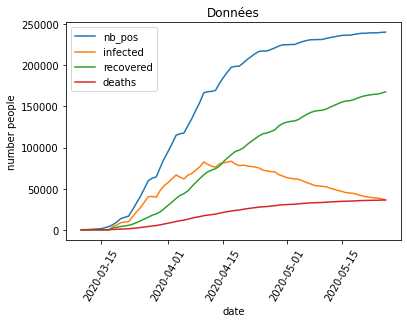

In [21]:
plot_cols = ['nb_pos', 'infected', 'recovered', 'deaths']
plt.title('Données')
plt.plot(data[plot_cols])
plt.ylabel('number people')
plt.xlabel('date')
plt.xticks(rotation=60)
plt.legend(plot_cols)
plt.show()

## Modele SIR

In [22]:
_params = (BETA, GAMMA, DELTA) = 1.0, 0.5, 1.0

#adapter t à l'intervalle de nos données 
t=np.arange(0,aggr_tests_latest.shape[0])

N=1000000 #population en France
I=aggr_tests_latest['nb_pos']
y = [N-I[0], I, 0]
y_0 = [N-I[0], I[0], 0]

78
SIRModel(
	β = 0.2902 ± 0.0062,
	ɣ = 0.0924 ± 0.0054
)R0 = 3.1416



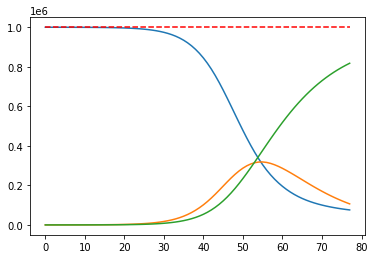

In [23]:
model=SIRModel(beta=BETA,gamma=GAMMA, N = N)
print(len(y[1]))
y_t = model.fit(t, y, N).predict(t, y_0)
print(model)

plt.plot(t,y_t[0])
plt.plot(t,y_t[1])
plt.plot(t,y_t[2])
plt.plot(t,y_t[0]+y_t[1]+y_t[2],"r--")
plt.show()

## Modele SEIR

In [24]:
from model import SEIRModel as SEIR
from model import SIRModel as SIR

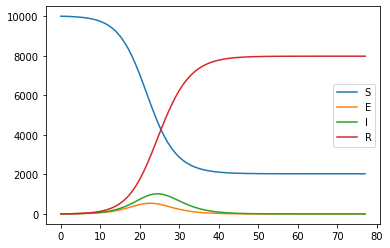

SEIRModel(
	β = 1.0000 ± 0.0000,
	ɣ = 0.5000 ± 0.0000,
	δ = 1.0000 ± 0.0000
)R0 = 2.0000



In [25]:
model = SEIR(gamma=GAMMA, beta=BETA, delta=DELTA)
y_t = model.predict(t, (10000, 10, 0, 0))
for y, l in zip(y_t, ('S', 'E', 'I', 'R')):
    plt.plot(t, y, label=l)
plt.legend()
plt.show()
model.fit(t, y_t)
print(model)
assert np.allclose(model.params, _params)

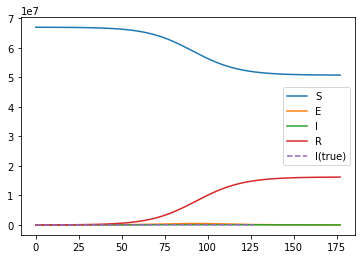

SEIRModel(
	β = 4.2427 ± 0.1926,
	ɣ = 3.7048 ± 0.1461,
	δ = 0.6249 ± 0.0317
)R0 = 1.1452



In [46]:
shift = 50

#adapter t à l'intervalle de nos données 
t=np.arange(0,data.shape[0]+shift)
t_long=np.arange(0,data.shape[0]+2*shift)

N=67000000 #population en France
I=np.concatenate((np.zeros(shift), data.infected))
E0 = 2000
y = [N-E0, E0, I, 0]
y_0 = [N-E0, E0, 0, 0]

model = SEIR(gamma=GAMMA, beta=BETA, delta=DELTA, N=N)
y_t = model.fit(t, y).predict(t_long, y_0)
for yi, l in zip(y_t, ('S', 'E', 'I', 'R')):
    plt.plot(t_long, yi, label=l)
plt.plot(I, "--", label='I(true)')
plt.legend()
plt.show()

print(model)

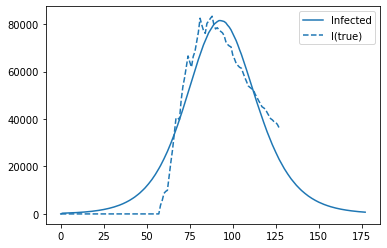

In [47]:
plt.plot(t_long, y_t[2], label='Infected')
plt.plot(I, "--", color='C0', label='I(true)')
plt.legend()
plt.show()

## Modele SEIRD

In [28]:
from model import SEIRDModel as SEIRD
import numpy as np
import matplotlib.pyplot as plt

noise = lambda v, s: np.random.normal(v, s)

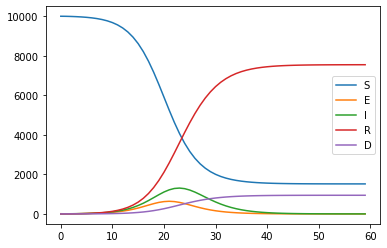

SEIRDModel(
	β = 1.3305 ± 0.1004,
	ɣ = 0.5100 ± 2739.2836,
	δ = 0.4414 ± 0.0581,
	ρ = 0.3186 ± 9365.5666,
	α = 0.1545 ± 4540.9537
)R0 = 2.6085



In [30]:
_params = (BETA, GAMMA, DELTA, RHO, ALPHA) = 1.0, 0.5, 1.0, 1/4, 0.2

model = SEIRD(gamma=GAMMA, beta=BETA, delta=DELTA, rho=RHO, alpha=ALPHA)

t = np.arange(0,60)
y_t = model.predict(t, (10000, 10, 0, 0, 0))

for y, l in zip(y_t, ('S', 'E', 'I', 'R', 'D')):
    plt.plot(t, y, label=l)
plt.legend()
plt.show()
model.fit(t, noise(y_t, 10))
print(model)

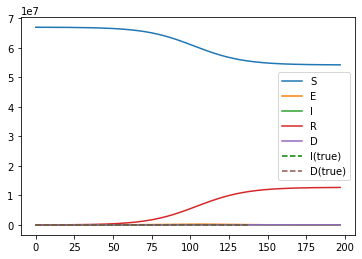

SEIRDModel(
	β = 2.8897 ± 0.2516,
	ɣ = 2.5979 ± 2.4489,
	δ = 0.7569 ± 0.0687,
	ρ = 8.7568 ± 7752.0565,
	α = 0.0011 ± 0.9450
)R0 = 1.1123



In [36]:
shift = 60

#adapter t à l'intervalle de nos données 
t=np.arange(0,data.shape[0]+shift)
t_long=np.arange(0,data.shape[0]+2*shift)

N=67000000 #population en France
I=np.concatenate((np.zeros(shift), data.infected))
D=np.concatenate((np.zeros(shift), data.deaths))
E0=2000
y = [N-E0, E0, I, 0, D]
y_0 = [N-E0, E0, 0, 0, 0]

model = SEIRD(gamma=GAMMA, beta=BETA, delta=DELTA, N=N)
y_t = model.fit(t, y).predict(t_long, y_0)
for yi, l in zip(y_t, ('S', 'E', 'I', 'R', 'D')):
    plt.plot(t_long, yi, label=l)
plt.plot(I, "--", color='green', label='I(true)')
plt.plot(D, "--", color='C5', label='D(true)')
plt.legend()
plt.show()

print(model)

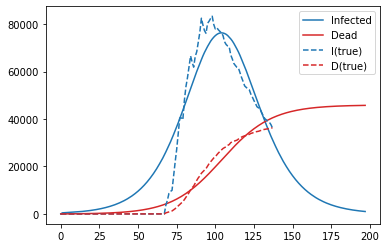

In [45]:
for yi, l, c in zip(y_t[2::2], ('Infected', 'Dead'), ('C0', 'C3')):
    plt.plot(t_long, yi, color=c, label=l)
plt.plot(I, "--", color='C0', label='I(true)')
plt.plot(D, "r--", color='C3', label='D(true)')
plt.legend()
plt.show()